In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import copy
from PIL import Image
import io
from torchvision import transforms
import torch.nn.functional as F

# Helper Functions

In [2]:
def getNumFromOneHot(inp):
    for i in range(10):
        if inp[i] == 1:
            return i

In [3]:
def draw_stroke_sequence(sequence):
    """
    sequence: numpy array or list of shape (T, 4) where each row is [dx, dy, eos, eod]
    save_path: optional path to save the plot as an image
    show: whether to display the plot
    """
    x, y = 0, 0
    xs, ys = [], []

    for dx, dy, eos, eod in sequence:
        x += dx*28
        y += dy*28
        xs.append(x)
        ys.append(y)

        if eos > 0.5:  # end of stroke
            xs.append(None)
            ys.append(None)

        if eod > 0.5:
            break

    # Load onto variable img_array
    plt.figure(figsize=(1, 1), dpi=28)  # 1 inch * 28 dpi = 28 pixels
    plt.plot(xs, ys, color = "black", linewidth=2)
    plt.gca().invert_yaxis()
    plt.axis('off')
    plt.axis('equal')
    # Use a BytesIO buffer to save the plot into memory
    buf = io.BytesIO()
    plt.savefig(buf, format='png', transparent=False, facecolor='white')
    plt.close()
    buf.seek(0)  # Rewind the buffer to the beginning
    img = Image.open(buf)  # Open the image from the buffer
    
    img_array = np.array(img.convert('L'))  # Convert to grayscale (1 channel) as a numpy array
    
    buf.close()  # Close the buffer
    
    return img_array

# 1. Loading the Models

In [4]:
class DigitToStrokeLSTM(nn.Module):
    def __init__(self, hidden_size=256, num_layers=2, batch_size=32):
        super(DigitToStrokeLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        
        self.embedding = nn.Linear(10, hidden_size)  # From one-hot to hidden dim
        
        # LSTM
        # Output layer: predicts [dx, dy, eos, eod]
        # Inital hidden state is the one-hot of number
        # Initial input is [0, 0, 0, 0, 0]
        # Input at t > 0 is output from t-1
        
        self.lstm = nn.LSTM(
            input_size=4,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.3
        )

        # Output layer: predicts [dx, dy, eos, eod]
        self.output_head = nn.Linear(hidden_size, 4)
        self.dropout = nn.Dropout(p=0.1)
        self.sigmoid = nn.Sigmoid()  # For eos/eod
        self.tanh = nn.Tanh()


    def forward(self, x, hidden=None, onehot_digit=None):
        
        if onehot_digit != None and hidden == None:
            # Embed the digit
            h0 = self.embedding(onehot_digit)
            h0 = h0.unsqueeze(0).repeat(self.num_layers, 1, 1)
            c0 = torch.zeros_like(h0)
            hidden = (h0, c0)

        elif hidden == None and onehot_digit == None:
            hidden = (torch.zeros(self.num_layers, self.batch_size, self.hidden_size),
                      torch.zeros(self.num_layers, self.batch_size, self.hidden_size))
            
        out, hidden = self.lstm(x, hidden)
        out = self.dropout(out)
        
        out = self.output_head(out)
        
        out[:, :, 0:2] = self.tanh(out[:, :, 0:2])
        # out[:, :, 2:] = self.sigmoid(out[:, :, 2:])
        
        return out, hidden
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        self.model = nn.Sequential(
            # First Convolution Block
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # 32 filters, 3x3 kernel, 'same' padding
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),  # 32 filters, 3x3 kernel, 'same' padding
            nn.BatchNorm2d(32),
            
            nn.MaxPool2d(2, 2),  # Max pooling (2x2) with stride 2
            nn.Dropout(0.25),

            # Second Convolution Block
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # 64 filters, 3x3 kernel, 'same' padding
            nn.BatchNorm2d(64),
            
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  # 64 filters, 3x3 kernel, 'same' padding
            nn.BatchNorm2d(64),

            nn.MaxPool2d(2, 2),  # Max pooling (2x2) with stride 2
            nn.Dropout(0.25),

            # Fully Connected (Dense) layers
            nn.Flatten(),
            
            nn.Linear(64 * 7 * 7, 512),  # Input size depends on the output of convolutional layers
            nn.BatchNorm1d(512),
            nn.Dropout(0.25),
            
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.5),
            
            nn.Linear(1024, 10)  # Output layer (10 classes)
        )
            
            

    def forward(self, x):
        x = self.model(x)
        return x

In [6]:
# Function to draw the number using the RNN

def generate_text(model, number):
    model.eval()
    
    temp_onehot = np.zeros(10)
    temp_onehot[number] = 1
    temp_onehot = torch.tensor(temp_onehot, dtype=torch.float32).to(device)
    
    initial_input = torch.tensor([0, 0, 0, 0], dtype=torch.float32).to(device).unsqueeze(0).unsqueeze(1)
    
    outputs = []
    
    output, hidden = model(initial_input, onehot_digit=temp_onehot)
    output[..., 2:] = (torch.sigmoid(output[..., -1, 2:]) > 0.5).float()

    outputs.append(output[:, -1, :].detach().cpu().numpy()[0])

    for i in range(62-1):
        output, hidden = model(output, hidden=hidden)
        output[..., 2:] = (torch.sigmoid(output[..., -1, 2:]) > 0.5).float()
        outputs.append(output[:, -1, :].detach().cpu().numpy()[0])
        
        # print(outputs[-1])
        if output[:, -1, 3] == 1:
            # print("HI")
            break
    
    return draw_stroke_sequence(outputs)


In [7]:
# Function to read an image and return the predicted digit

def evaluate_img(model, img, display=False):
    # Step 2: Preprocess the image
    transform = transforms.Compose([
        transforms.ToTensor()  # Convert to PyTorch tensor (scales pixels to [0, 1])
    ])

    img_tensor = transform(img).to(device)

    img_tensor[img_tensor<0.6] = 0
    img_tensor[img_tensor>=0.6] = 1

    img_tensor = 1-img_tensor

    if display:
        imgDisplay = img_tensor.squeeze(0).squeeze(0).cpu().numpy()  # Remove batch and channel dimensions

        # Display the image using matplotlib
        plt.imshow(imgDisplay, cmap='gray')
        plt.axis('off')  # Turn off axis labels
        plt.show()


    # Step 3: Add batch dimension (PyTorch models expect a batch of images)
    img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension (1, 1, 28, 28)

    # Step 4: Pass the tensor to the model
    model.eval()  # Ensure the model is in evaluation mode
    with torch.no_grad():  # Turn off gradients since we're in inference mode
        output = model(img_tensor)  # Pass the image tensor to the model for prediction

    # Step 5: Interpret the output
    _, predicted_class = torch.max(output, 1)  # Get the predicted class index
    
    # First return is the predicted class (int), and the second is an array containing confidences for each digit
    return predicted_class.item(), nn.Softmax(dim=1)(output).detach().cpu().numpy()[0]

### Draw and Compare

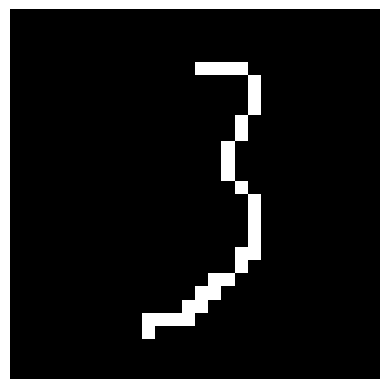

Predicted Class: 3
Confidence of desired_digit = 0.7381200194358826


In [8]:
rnnModel = DigitToStrokeLSTM(hidden_size = 512, num_layers=2).to(device)
rnnModel.load_state_dict(torch.load(f'model_weights/sketch_model_weights1.pth', weights_only=True))
rnnModel.eval()  # set to evaluation mode if you're doing inference

cnnEvaluator = CNNModel().to(device)
cnnEvaluator.load_state_dict(torch.load('../classify_cnn/cnn_weights/cnn_weights1.pth', weights_only=True))
cnnEvaluator.eval()  # set to evaluation mode if you're doing inference


# Test if the loaded model works
desired_digit = 3 # <----- Change number and see it print it :)
example_img = generate_text(rnnModel, desired_digit)
predicted_class, confidence = evaluate_img(cnnEvaluator, example_img, display=True)
print(f'Predicted Class: {predicted_class}')
print(f'Confidence of desired_digit = {confidence[desired_digit]}')

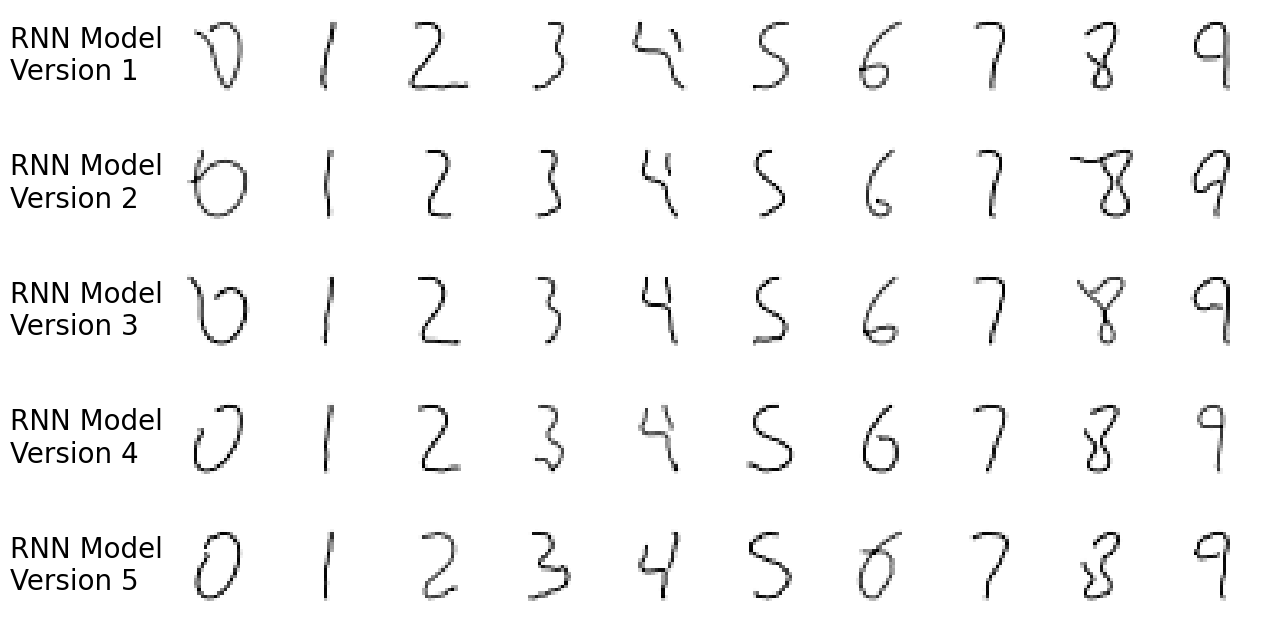

In [36]:
fig = plt.figure(figsize=(14,8))
i = 0
axes = []

for j in range(5):
    rnnModel = DigitToStrokeLSTM(hidden_size = 512, num_layers=2).to(device)
    rnnModel.load_state_dict(torch.load(f'model_weights/sketch_model_weights{j+1}.pth', weights_only=True))
    rnnModel.eval()  # set to evaluation mode if you're doing inference
    
    for m in range(10):
        ax = plt.subplot(5, 10, i+1)
        example_img = generate_text(rnnModel, m)
        plt.imshow(example_img, cmap='gray')
        plt.axis('off')  # Turn off axis labels
        # if (i)%10 == 0: plt.title(f'RNN Model Version {j+1}')
        axes.append(ax)
        i += 1
        
for row in range(5):
    first_ax = axes[row * 10]
    last_ax = axes[row * 10 + 9]
    y_mid = (first_ax.get_position().y0 + last_ax.get_position().y1) / 2
    fig.text(0.01, y_mid, f'RNN Model\nVersion {row+1}', va='center', ha='left', fontsize=20)
        
plt.show()

### Check evaluate hand-writing with CNN

In [9]:
total = 0
sum = 0

for i in range(1, 6):
    rnnModel = DigitToStrokeLSTM(hidden_size = 512, num_layers=2).to(device)
    rnnModel.load_state_dict(torch.load(f'model_weights/sketch_model_weights{i}.pth', weights_only=True))
    rnnModel.eval()  # set to evaluation mode if you're doing inference

    cnnEvaluator = CNNModel().to(device)
    cnnEvaluator.load_state_dict(torch.load(f'../classify_cnn/cnn_weights/cnn_weights{i}.pth', weights_only=True))
    cnnEvaluator.eval()  # set to evaluation mode if you're doing inference

    for j in range(10):
        # Test if the loaded model works
        img = generate_text(rnnModel, j) # <----- Change number and see it print it :)
        
        predicted_class, _ = evaluate_img(cnnEvaluator, img, display=False)
        
        
        if predicted_class == j:
            sum += 1
        else:
            print(f'Model: {i} Desired Class: {j} Predicted Class: {predicted_class}')
        total+= 1
        
print(f"Accuracy {sum/total}")

Model: 1 Desired Class: 0 Predicted Class: 7
Model: 1 Desired Class: 6 Predicted Class: 5
Model: 1 Desired Class: 9 Predicted Class: 4
Model: 2 Desired Class: 8 Predicted Class: 7
Model: 3 Desired Class: 6 Predicted Class: 5
Model: 3 Desired Class: 9 Predicted Class: 4
Model: 4 Desired Class: 9 Predicted Class: 7
Model: 5 Desired Class: 6 Predicted Class: 5
Model: 5 Desired Class: 9 Predicted Class: 7
Accuracy 0.82


In [ ]:
rnn_acc = []
rnn_totalconf = []

for i in range(5):
    rnnModel = DigitToStrokeLSTM(hidden_size = 512, num_layers=2).to(device)
    rnnModel.load_state_dict(torch.load(f'model_weights/sketch_model_weights{i+1}.pth', weights_only=True))
    rnnModel.eval()  # set to evaluation mode if you're doing inference
    
    rnn_score = []
    rnn_conf = []

    for j in range(5):
        cnnEvaluator = CNNModel().to(device)
        cnnEvaluator.load_state_dict(torch.load(f'../classify_cnn/cnn_weights/cnn_weights{j+1}.pth', weights_only=True))
        cnnEvaluator.eval()  # set to evaluation mode if you're doing inference

        accuracy = 0
        confidence = 0
        
        for m in range(10):
            # Test if the loaded model works
            img = generate_text(rnnModel, m) # <----- Change number and see it print it :)
            
            predicted_class, _ = evaluate_img(cnnEvaluator, img, display=False)
            
            confidence += _[m]
            
            if predicted_class == m:
                accuracy += 1
                
                
        accuracy = accuracy/10.0
        confidence = confidence/10.0
        print(f"Finished rnnModel{i+1} with cnnEvaluator{j+1}, acc: {accuracy}")
        
        rnn_score.append(accuracy)
        rnn_conf.append(confidence)
    
    print()
    rnn_acc.append(rnn_score)
    rnn_totalconf.append(rnn_conf)
    print(f'Mean: {np.mean(rnn_score)}')
    print(f'std: {np.std(rnn_score)}')

Finished rnnModel1 with cnnEvaluator1, acc: 0.7
Finished rnnModel1 with cnnEvaluator2, acc: 0.7
Finished rnnModel1 with cnnEvaluator3, acc: 0.6
Finished rnnModel1 with cnnEvaluator4, acc: 0.7
Finished rnnModel1 with cnnEvaluator5, acc: 0.7

Mean: 0.68
std: 0.039999999999999994
Finished rnnModel2 with cnnEvaluator1, acc: 0.8
Finished rnnModel2 with cnnEvaluator2, acc: 0.9
Finished rnnModel2 with cnnEvaluator3, acc: 0.6
Finished rnnModel2 with cnnEvaluator4, acc: 0.7
Finished rnnModel2 with cnnEvaluator5, acc: 0.7

Mean: 0.74
std: 0.10198039027185572
Finished rnnModel3 with cnnEvaluator1, acc: 0.9
Finished rnnModel3 with cnnEvaluator2, acc: 1.0
Finished rnnModel3 with cnnEvaluator3, acc: 0.8
Finished rnnModel3 with cnnEvaluator4, acc: 1.0
Finished rnnModel3 with cnnEvaluator5, acc: 0.9

Mean: 0.9200000000000002
std: 0.0748331477354788
Finished rnnModel4 with cnnEvaluator1, acc: 0.9
Finished rnnModel4 with cnnEvaluator2, acc: 0.9
Finished rnnModel4 with cnnEvaluator3, acc: 0.9
Finished rn

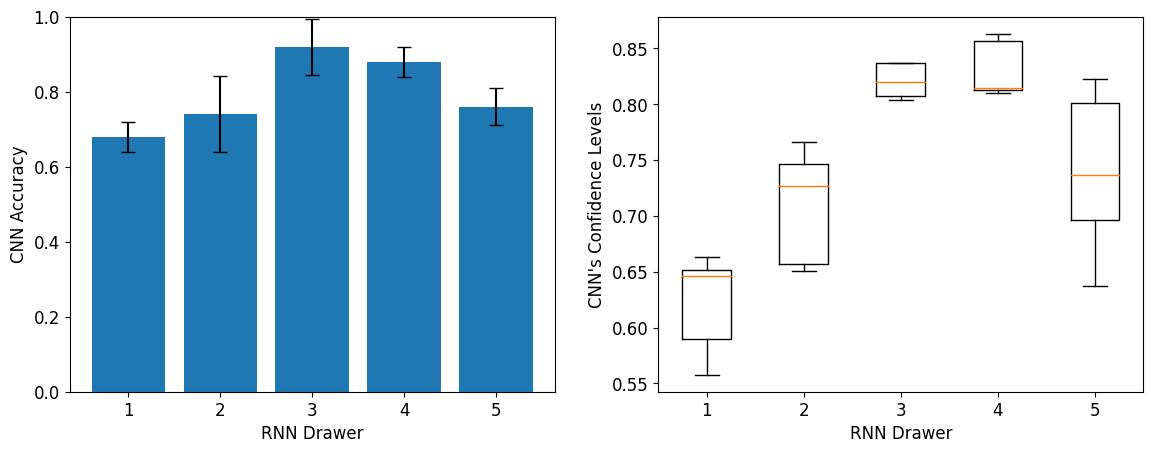

In [53]:
plt.rcParams.update({
    'font.size': 8,
    'axes.labelsize': 12,
    'axes.titlesize': 9,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 7,
    'font.family': 'sans-serif',
    'savefig.dpi': 300
})

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

labels = ['1', '2', '3', '4', '5']

x = np.arange(len(rnn_acc))
rnn_acc_means = [np.mean(i) for i in rnn_acc]
rnn_acc_std = [np.std(i) for i in rnn_acc]

axs[0].bar(x, rnn_acc_means, yerr=rnn_acc_std, capsize=5, tick_label=labels)
axs[0].set_ylabel('CNN Accuracy')
axs[0].set_xlabel("RNN Drawer")
axs[0].set_ylim(0, 1.0)


axs[1].boxplot(rnn_totalconf, labels=labels, showfliers=False)
axs[1].set_ylabel('CNN\'s Confidence Levels')
axs[1].set_xlabel("RNN Drawer")

plt.tight_layout(pad=3)
plt.show()

# 2. Lesion the Model

In [76]:
# DAMAGE WEIGHTS

def damage_smallest(model, p_smallest): # energy constraint
    for name, param in model.named_parameters():
        if param.requires_grad and param.ndim >= 2:
            if p_smallest == 0:
                continue

            tensor = param.data
            weight_magnitudes = tensor.abs().view(-1)
            k = int(weight_magnitudes.numel() * p_smallest)

            if k == 0:
                continue
            threshold = weight_magnitudes.kthvalue(k).values.item()

            mask = tensor.abs() >= threshold
            param.data.mul_(mask)

def damage_fas(model, p_block, p_reflect, p_filter):
    for name, param in model.named_parameters():
        if param.requires_grad and param.ndim >= 2:
            if p_block + p_reflect + p_filter == 0:
                continue

            tensor = param.data
            flat_weights = tensor.view(-1)
            nonzero_indices = (flat_weights!=0).nonzero(as_tuple=True)[0]
            num_nonzero_indices = nonzero_indices.numel()
            if num_nonzero_indices == 0:
                continue

            # percentage of weights damaged will be taken from the number of nonzero weights
            # simulated fas damage occurs after energy constraint blockage
            num_block = int(num_nonzero_indices * p_block)
            num_reflect = int(num_nonzero_indices * p_reflect)
            num_filter = int(num_nonzero_indices * p_filter)

            shuffled_indices = nonzero_indices[torch.randperm(num_nonzero_indices, device=flat_weights.device)]

            indices_block = shuffled_indices[:num_block]
            indices_reflect = shuffled_indices[num_block:num_block+num_reflect]
            indices_filter = shuffled_indices[num_block+num_reflect:num_block+num_reflect+num_filter]

            # do damage
            # blockage: set weights to 0
            if p_block != 0:
                flat_weights[indices_block] = 0

            # reflect: halve weights
            if p_reflect != 0:
                flat_weights[indices_reflect] *= 0.5

            # filter: low pass filter (lusch et al)
            if p_filter != 0:
                weights_to_filter = flat_weights[indices_filter]            # get weights before transformation
                signs = torch.sign(weights_to_filter)                       # get signs of weights
                abs_weights_to_filter = weights_to_filter.abs()             # get high_weight, should be in the 95th percentile for all weights
                high_weight = torch.quantile(flat_weights.abs(), 0.95)      # scale weights to mostly between -1 and 1
                x = abs_weights_to_filter / high_weight
                transformed_weights = -0.2744 * x**2 + 0.9094 * x - 0.0192
                gaussian_noise = torch.randn_like(transformed_weights) * 0.05
                transformed_weights += gaussian_noise
                transformed_weights = transformed_weights * signs * high_weight # rescale
                flat_weights[indices_filter] = transformed_weights


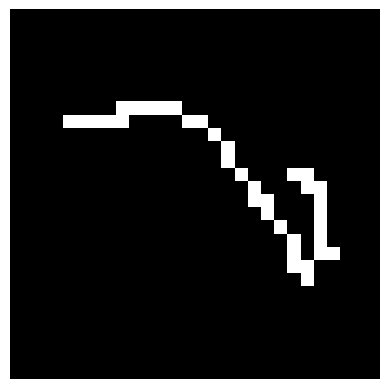

Predicted Class: 7
Confidence of desired_digit = 2.669275545486016e-06


In [100]:
copy_model = copy.deepcopy(rnnModel)

# Do Damage
damage_smallest(copy_model, 0)
damage_fas(copy_model, 0.1, 0, 0)

# Predict

desired_digit = 3 # <----- Change number and see it print it :)
test_img = generate_text(copy_model, desired_digit)
predicted_class, confidence = evaluate_img(cnnEvaluator, test_img, display=True)
print(f'Predicted Class: {predicted_class}')
print(f'Confidence of desired_digit = {confidence[desired_digit]}')

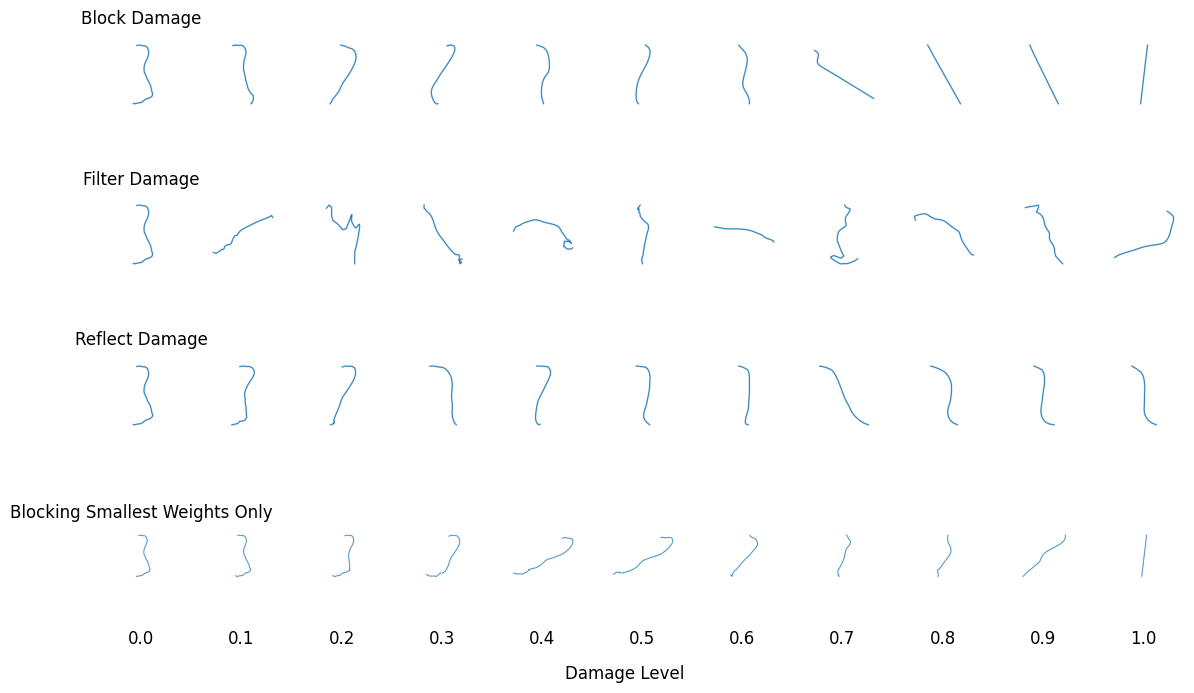

In [33]:
import matplotlib.image as mpimg
fig = plt.figure(figsize=(14,8))
i = 0

for j in ['block', 'filter', 'reflect', 'smallest']:
    for m in ['0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0']:
        
        ax = plt.subplot(4, 11, i + 1)
        img = mpimg.imread('images/model2_drawings/'+j+'/3_'+m+'.png')  
        ax.imshow(img, cmap='gray')
        ax.axis('off')  # Turn off axis labels

        # Add bottom labels only for the bottom row
        if i >= 33:
            ax.text(0.5, -0.75, m, transform=ax.transAxes, fontsize=12, ha='center', va='top')


        if (i)%11 == 0: 
            if j == 'smallest':
                ax = plt.subplot(4, 11, i + 1)
                plt.title("Blocking Smallest Weights Only")
            else:
                plt.title(j.title() +' Damage')
        
        i += 1

fig.text(0.5, 0.04, 'Damage Level', ha='center', fontsize=12)
plt.show()